# Argentina´s Hourly Energy Consumption

The aim of this project is to find out if there is a saving in energy consumption by applying different time zones. Nowadays Argentina has UTC-3 time zone even though most of its area is on UTC-4 time zone. 

To do so I will start by adding features to the dataset that explain energy hourly consumption, such as temperature, precipitations, solar radiation, dusk and dawn hours and economic activity level. In the end, the idea is to go from a time series dataset, to a dataset compound of different features that explain energy consumption.

Finally, I will train a model to predict future consumption by changing just the clock hour, remaining other features constant. In that way I will evaluate if savings in energy consumption can be achieved by applying different time zones.

Sources: Cammesa, Indec, Fundación Fiel, Meteostat, www.salidaypuestadelsol.com, NASA (https://power.larc.nasa.gov/data-access-viewer/)

In [1]:
# Instalation of packages
# pip install category_encoders
# pip install meteostat
# pip install xgboost
# pip install plotly==5.8.0

In [178]:
# Import libraries needed
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from datetime import datetime
from meteostat import Hourly, Stations
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## 1) Time Series Dataset

### A. Data Importation & Wrangling

In [3]:
# Read Excel with energy consumption into a DataFrame and print first 5 rows
df = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/Base de datos Horaria-Diaria 2018-2022.xlsx')
df.head()

AÑO        MES  N° MES  N° DIA TIPO DIA                DIA      FECHA  \
0  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
1  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
2  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
3  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   
4  2018 2018-01-01       1       1  DOMINGO  Domingo o Feriado 2018-01-01   

   HORA  Gran Usuario MEM  DISTRIBUIDOR (demanda estacional+GUMEs)  \
0     1          1571.489                                11543.982   
1     2          1569.442                                11178.772   
2     3          1568.841                                10881.543   
3     4          1562.213                                10552.008   
4     5          1558.532                                10288.264   

   DEMANDA LOCAL [MWh]  Exportacion  Bombeo  Perdidas  DEMANDA TOTAL [MWh]  
0            13115.471          0.0     0.0   173.668            13289.139  
1            12748.214          0.0     0.0   496.059            13244.273  
2            12450.384          0.0     0.0   514.231            12964.615  
3            12114.221          0.0     0.0   428.026            12542.247  
4            11846.796          0.0     0.0   321.763            12168.559

I will proceed to understand info and keep what I want for analysis:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37944 entries, 0 to 37943
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   AÑO                                      37944 non-null  int64         
 1   MES                                      37944 non-null  datetime64[ns]
 2   N° MES                                   37944 non-null  int64         
 3   N° DIA                                   37944 non-null  int64         
 4   TIPO DIA                                 37944 non-null  object        
 5   DIA                                      37944 non-null  object        
 6   FECHA                                    37944 non-null  datetime64[ns]
 7   HORA                                     37944 non-null  int64         
 8   Gran Usuario MEM                         37944 non-null  float64       
 9   DISTRIBUIDOR (demanda estacional+GUMEs)

In [5]:
df.describe()

AÑO        N° MES        N° DIA          HORA  \
count  37944.000000  37944.000000  37944.000000  37944.000000   
mean    2019.690070      6.217584     15.714105     12.500000   
std        1.262058      3.496059      8.792642      6.922278   
min     2018.000000      1.000000      1.000000      1.000000   
25%     2019.000000      3.000000      8.000000      6.750000   
50%     2020.000000      6.000000     16.000000     12.500000   
75%     2021.000000      9.000000     23.000000     18.250000   
max     2022.000000     12.000000     31.000000     24.000000   

       Gran Usuario MEM  DISTRIBUIDOR (demanda estacional+GUMEs)  \
count      37944.000000                             37944.000000   
mean        2127.233236                             12837.282505   
std          251.857492                              2514.899029   
min           57.231000                               291.567000   
25%         1976.229250                             10962.396500   
50%         2171.293000                             12596.824500   
75%         2298.279750                             14375.947000   
max         2844.364000                             24010.083000   

       DEMANDA LOCAL [MWh]   Exportacion        Bombeo      Perdidas  \
count         37944.000000  37944.000000  37944.000000  37944.000000   
mean          14964.515741    197.928317     55.334882    496.318437   
std            2581.627657    486.012685    149.522024    149.395838   
min             369.063000      0.000000      0.000000   -264.264000   
25%           13038.432250      0.000000      0.000000    389.957500   
50%           14755.009500      0.000000      0.000000    469.034500   
75%           16562.277750      0.000000      1.055000    577.362000   
max           25908.691000   2938.546000    992.705000   1326.988000   

       DEMANDA TOTAL [MWh]  
count         37944.000000  
mean          15714.097377  
std            2629.706504  
min             105.597000  
25%           13788.418750  
50%           15462.325000  
75%           17381.320250  
max           27049.851000

In [6]:
print(df.select_dtypes('object').nunique())
df['TIPO DIA'].unique()

TIPO DIA    3
DIA         7
dtype: int64


array(['DOMINGO', 'HABIL', 'SABADO'], dtype=object)

Some columns repeat info ("N° MES" and "FECHA") and some columns have information we won´t use ("Exportacion", "Bombeo", "Perdidas"...)

In [7]:
# List columns to drop:
drop_cols = ['MES', 'DIA', 'Gran Usuario MEM', 'DISTRIBUIDOR (demanda estacional+GUMEs)', 'Exportacion', 'Bombeo', 'Perdidas', 'DEMANDA TOTAL [MWh]']

# Drop columns:
df.drop(drop_cols, axis=1, inplace=True)

# Adjust hours to 0-23 instead of 1-24
df['HORA'] = df['HORA'] - 1

# Define "FECHA" as index:
# df.set_index('FECHA', inplace=True)
df.head()

AÑO  N° MES  N° DIA TIPO DIA      FECHA  HORA  DEMANDA LOCAL [MWh]
0  2018       1       1  DOMINGO 2018-01-01     0            13115.471
1  2018       1       1  DOMINGO 2018-01-01     1            12748.214
2  2018       1       1  DOMINGO 2018-01-01     2            12450.384
3  2018       1       1  DOMINGO 2018-01-01     3            12114.221
4  2018       1       1  DOMINGO 2018-01-01     4            11846.796

I wil rename columns to unify language and for better understanding:

AÑO --> Year
N° MES --> Month
N° DIA --> Day
TIPO DIA --> Day Type: If it is weekday, weekend or national holliday.
FECHA --> Date
HORA --> Hour
DEMANDA LOCAL [MWh] --> Consumption [MWh]: Energy Hourly Consumption in MWh

In [8]:
df.rename(columns={'AÑO': 'Year', 'N° MES': 'Month', 'N° DIA': 'Day', 'TIPO DIA': 'Day Type', 'FECHA': 'Date', 
                   'HORA': 'Hour', 'DEMANDA LOCAL [MWh]': 'Consumption [MWh]'}, inplace=True)
df['Day Type'].replace({'DOMINGO': 'Sunday', 'SABADO': 'Saturday', 'HABIL': 'Working day'}, inplace=True)
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]
0  2018      1    1   Sunday 2018-01-01     0          13115.471
1  2018      1    1   Sunday 2018-01-01     1          12748.214
2  2018      1    1   Sunday 2018-01-01     2          12450.384
3  2018      1    1   Sunday 2018-01-01     3          12114.221
4  2018      1    1   Sunday 2018-01-01     4          11846.796

Let´s check if there are missing values:

In [9]:
df.isna().sum()

Year                 0
Month                0
Day                  0
Day Type             0
Date                 0
Hour                 0
Consumption [MWh]    0
dtype: int64

### B. EDA

Now I have the info I need. I will start EDA to find insights in data:

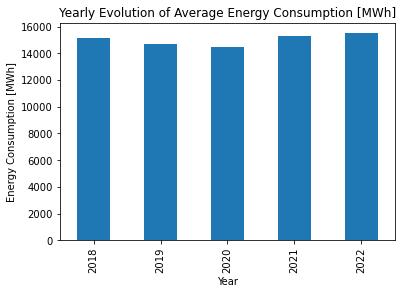

In [10]:
# Group energy consumption by year (info untill 31/3/2022)
df.groupby('Year')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Yearly Evolution of Average Energy Consumption [MWh]');

2020 was the Year with the lowest energy consumption of the series. Lockdown for sure affect industry and economy. Adding a feature as economy activity level will help to explain this variation.

On the other hand, 2022 has the higher consumption but that seems reasonable as it just has summer info, where consumption is higher.

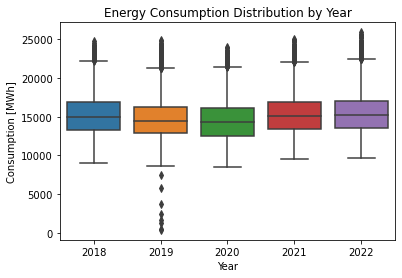

In [11]:
sns.boxplot(x='Year', y='Consumption [MWh]', data=df)
plt.title('Energy Consumption Distribution by Year');

We can see from the boxplots that there are peaks of consumption in every year, but just in 2019 there are outliers of minimum consumption. 

Let´s check for those minimum values:

In [12]:
df[df['Year'] == 2019][['Date','Hour', 'Consumption [MWh]']].sort_values(by='Consumption [MWh]').head(10)

Date  Hour  Consumption [MWh]
12752 2019-06-16     8            369.063
12753 2019-06-16     9            531.163
12754 2019-06-16    10           1281.001
12751 2019-06-16     7           1630.631
12755 2019-06-16    11           2457.595
12756 2019-06-16    12           3707.707
12757 2019-06-16    13           5804.462
12758 2019-06-16    14           7490.366
12759 2019-06-16    15           8664.924
10399 2019-03-10     7           9198.249

9 out of 10 minimal values occur in 2019-06-16! Seems that on that day there was a massive blackout in Argentina, from 7 am to 3 pm:

https://www.infobae.com/sociedad/2019/06/16/masivo-apagon-a-nivel-pais-capital-federal-buenos-aires-y-varias-provincia-estan-sin-luz/

I will proceed to replace those values as we can see that are related to an external and explainable rare event with the average of previous and posterior Sunday:

In [13]:
# Set values to NaN:
df.loc[12751:12759, 'Consumption [MWh]'] = np.nan
# Slice previous and posterior Sunday, concatenate and calculate mean by hour: 
prev = df[(df['Date'] == '2019-06-09') & (df['Hour'] > 6) & (df['Hour'] < 16)]
post = df[(df['Date'] == '2019-06-23') & (df['Hour'] > 6) & (df['Hour'] < 16)]
prev_post = pd.concat([prev, post])
prev_post = prev_post[['Hour', 'Consumption [MWh]']].groupby('Hour').mean()
values = prev_post['Consumption [MWh]']
# Replace NaN values with average values:
df.loc[df['Consumption [MWh]'].isnull(),'Consumption [MWh]'] = df['Hour'].map(values)
df.loc[12751:12759]

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]
12751  2019      6   16   Sunday 2019-06-16     7         11430.7500
12752  2019      6   16   Sunday 2019-06-16     8         11191.3760
12753  2019      6   16   Sunday 2019-06-16     9         11639.0935
12754  2019      6   16   Sunday 2019-06-16    10         12131.0510
12755  2019      6   16   Sunday 2019-06-16    11         12375.1755
12756  2019      6   16   Sunday 2019-06-16    12         12405.2630
12757  2019      6   16   Sunday 2019-06-16    13         12208.4955
12758  2019      6   16   Sunday 2019-06-16    14         11896.8315
12759  2019      6   16   Sunday 2019-06-16    15         11847.8055

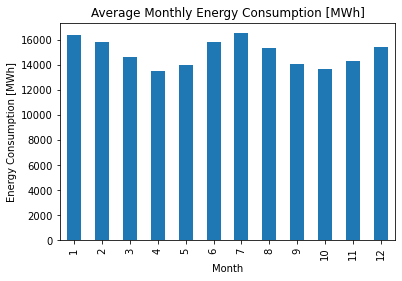

In [14]:
df.groupby('Month')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Monthly Energy Consumption [MWh]');

Consumption has it peaks in Summer's and Winter's months. High temperatures in Summer may affect consumption, as well as Winter's shorter days. I will create a new feature "Season" to go deeper in this analysis. 

In [15]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'autumn': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'winter': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'spring': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['winter']:
        return 'winter'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'summer'

# Assuming df has a date column of type `datetime`
df['season'] = df['Date'].map(season_of_date)

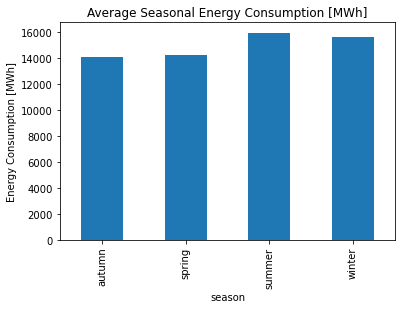

In [16]:
df.groupby('season')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('season')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Seasonal Energy Consumption [MWh]');

Summer is the season with higher energy consumption (and higher temperatures!), followed by Winter (lower temperatures!). 

Now I will plot average hourly consumption:

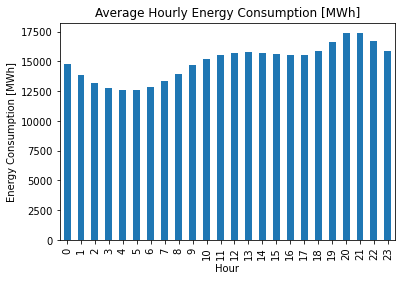

In [17]:
df.groupby('Hour')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]');

I will combine season with hourly consumption to see how consumption is affected by hour, temperature and daylight during the different seasons of the year:

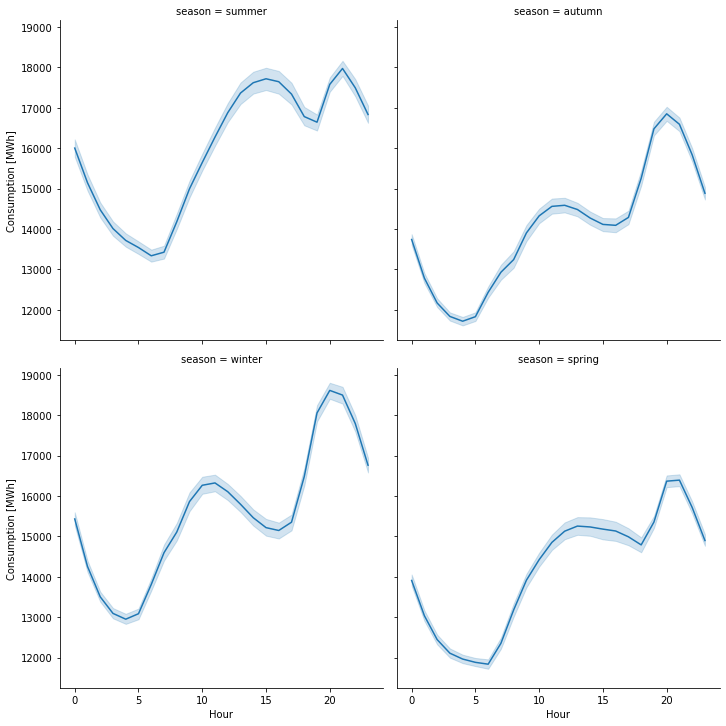

In [18]:
sns.relplot(x="Hour", y="Consumption [MWh]", data=df, kind="line", col="season", col_wrap=2)
plt.show()

Though curves are similar, there are some differences. To highlight them let's plot winter and summer curves together to understand better how energy consumption differs on those seasons:

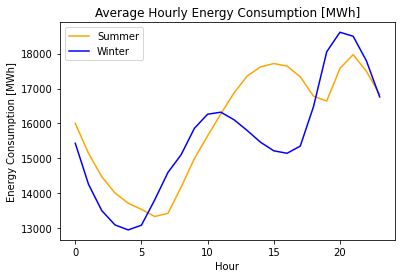

In [19]:
df[df['season'] == 'summer'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Summer', color='orange')
df[df['season'] == 'winter'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Winter', color='blue')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]')
plt.legend();

The beginning and end of both curves look alike but a couple of hours "earlier" for winter. Daylight may be impacting in energy consumption. 
On the other hand, we can see that daily peaks happened in hottest hours for summer and coldest for winter.

Adding features as temperature and daylight hours will definitely help us understand this kind of variations.

Now, I will check if there is variation between working days and weekends:

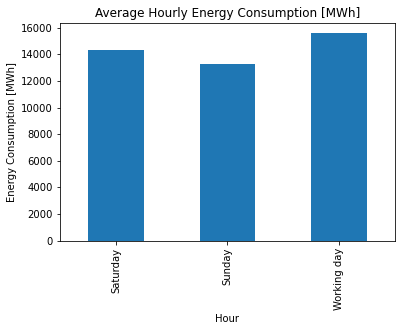

In [20]:
df.groupby('Day Type')['Consumption [MWh]'].mean().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]');

### C. Time Series Modeling

To end this first part of the project, I will develop a Time Series model to predict energy consumption with current information. This model will be the baseline to compare models in the second part of the project . I will choose an AutoRegressive model for timeseries forecasting.

In [21]:
# Create a column with datetime combining Date and Hour and setting it as index:
df['datetime'] = pd.to_datetime(df['Date']) + df['Hour'].astype('timedelta64[h]')
y = df[['datetime', 'Consumption [MWh]']]
y.set_index('datetime', inplace=True)
# Timeseries data in a pandas Series with Datetime as index and Consumption as target feature:
y = y.squeeze()
y.index.freq = 'h'
y.head()

datetime
2018-01-01 00:00:00    13115.471
2018-01-01 01:00:00    12748.214
2018-01-01 02:00:00    12450.384
2018-01-01 03:00:00    12114.221
2018-01-01 04:00:00    11846.796
Freq: H, Name: Consumption [MWh], dtype: float64

Moldel 0 will be the simplest model, predicting consumption base on the mean of the past information.

In [22]:
# Split data into train and test 
cutoff_test = int(0.75 * len(y))
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]
# Calculate a baseline error using the average energy consumption:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_test)
baseline_rmse = (mean_squared_error(y_test, y_pred_baseline) ** 0.5).round(2)
print("Mean Energy Consumption:", y_train_mean)
print("Baseline RMSE:", baseline_rmse)
# Store in a Dictionary each model´s performance:
model_performance = {'0 - Mean': baseline_rmse}
print(model_performance)

Mean Energy Consumption: 14840.60820245635
Baseline RMSE: 2681.08
{'0 - Mean': 2681.08}


To start with Autoregressive model I will plot de Partial Autorrelation function plot. This plot let us see partial correlation between a value with its own lagged values. It is important to determine the appropriate lags (p) in an AR model.

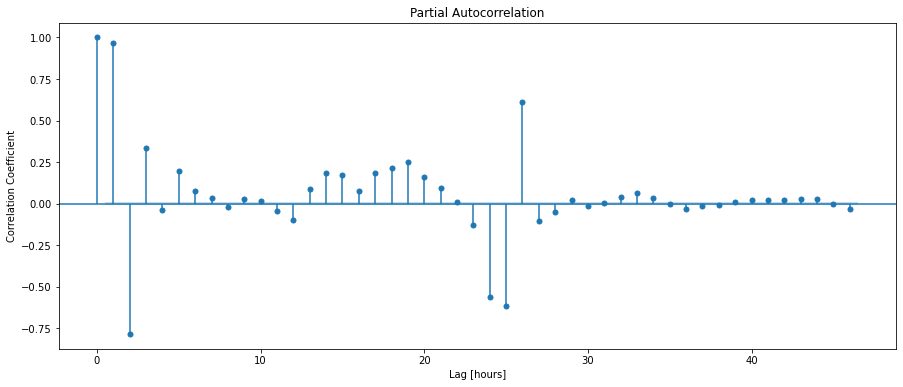

In [23]:
# Plotting pacf:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

I will define p = 26 and use that parameter in AR Model which it will be define in the next step:

In [24]:
# Lags p = 26. Fitting model with y_train:
p = 26
ar = AutoReg(y_train, lags=p, old_names=True).fit()
# Calculating Training RMSE:
y_pred = ar.predict().dropna()
training_rmse = (mean_squared_error(y_train[p:], y_pred) ** 0.5).round(2)
print("AR Training RMSE:", training_rmse)
# Calculating model performance in test data:
y_pred_test = ar.predict(y_test.index[0], y_test.index[-1])
test_rmse = (mean_squared_error(y_test, y_pred_test) ** 0.5).round(2)
print("AR Test RMSE:", test_rmse)
# Appending results to performance dictionary:
model_performance['1 - AR']= test_rmse
print(model_performance)

AR Training RMSE: 168.07
AR Test RMSE: 2660.49
{'0 - Mean': 2681.08, '1 - AR': 2660.49}


AR Model´s performance wasn't better than the simple mean. Let´s plot predictions vs test data to understand model´s performance:

In [25]:
# Create dataframe with two columns, test data and predictions:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index)
# Plot
fig = px.line(df_pred_test, labels={"value": "Consumption"})
fig.show()

It´s visible that the predictions over time become less and less accurate, similar to just predicting the mean. To solve this I will use walk forward validation, re-training the model with actual data as it gets available for further predictions.

In [26]:
# Build walk foward validation model:
y_pred_wfv = pd.Series(dtype='float64')
history = y_train.copy()
for i in range(len(y_test)):
    ar_wfv = AutoReg(history, lags=p, old_names=True).fit()
    next_pred = ar_wfv.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
# Calculate RMSE:
test_wfv_rmse = (mean_squared_error(y_test, y_pred_wfv) ** 0.5).round(2)
print("Test RMSE (walk forward validation):", test_wfv_rmse)
# Add RMSE to the performance dictionary:
model_performance['2 - AR_wfv'] = test_wfv_rmse
print(model_performance)

Test RMSE (walk forward validation): 171.53
{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53}


Really great performance! Let´s check it out in a plot:

In [27]:
# Create dataframe with two columns, test data and predictions:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_wfv}, index=y_test.index)
# Plot
fig = px.line(df_pred_test, labels={"value": "Consumption"})
fig.show()

First part of the project is finished. After importing data I perform EDA and develop 3 models for time series forecasting. New models will be develop in the second part of the project and performance will be compared.

## 2) New Features Dataset 

The goal of this part of the project is to add to time series dataset new features such as temperature, precipitations, sunrise and sunset hours, solar radiance and an indicator of economics/industrial activity level. 

I believe this new features will help me partially explain variations of consumption among the different years, seasons, days and hours. The only time related feature I intend to keep is clock´s hour, as this is what is going to be changed to find out if savings in energy consumption can be made by applying different time zones.

### A. Adding new features:

**First Step:**

As Argentina is a vast country this features will differ from North to South and from East to West. Problem is that Consumption target variable is aggregated for the whole country. In a different dataset I found monthly consumption divided by provinces. I will use this information to find the country´s weighted average center.

Having this center then I´ll be able to search for new features based on that location.

In [28]:
# Reading file into a DataFrame and printing first 5 rows:
df_month_prov = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/BASE_DEMANDA_INFORME_MENSUAL_2018-2022.xlsx')
df_month_prov.head()

AÑO        MES AGENTE NEMO            AGENTE DESCRIPCION TIPO AGENTE  \
0  2018 2018-01-01    AARGTAOY   AEROP ARG 2000 - Aeroparque          GU   
1  2018 2018-01-01    ABRILHCY           ABRIL CLUB DE CAMPO          GU   
2  2018 2018-01-01    ACARQQ3Y      ASOC.COOP.ARG. - Quequén          GU   
3  2018 2018-01-01    ACARSLSY  ASOC.COOP.ARG. - San Lorenzo          GU   
4  2018 2018-01-01    ACERBR1Y                Planta Bragado          GU   

         REGION     PROVINCIA    CATEGORIA AREA CATEGORIA DEMANDA  \
0   GRAN BS.AS.  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
1   GRAN BS.AS.  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
2  BUENOS AIRES  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   
3       LITORAL      SANTA FE  Gran Usuario MEM      Gran Usuario   
4  BUENOS AIRES  BUENOS AIRES  Gran Usuario MEM      Gran Usuario   

                  TARIFA             CATEGORIA TARIFA  DEMANDA [MWh]  
0  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande       2038.283  
1  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande       1581.397  
2  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande        343.544  
3  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande        584.431  
4  GUMAS/AUTOGENERADORES  Industrial/Comercial Grande      22043.186

PROVINCIA
BUENOS AIRES      0.492618
SANTA FE          0.094085
CORDOBA           0.074703
MENDOZA           0.044616
CHUBUT            0.033570
ENTRE RIOS        0.028096
TUCUMAN           0.023673
CHACO             0.022808
CORRIENTES        0.022043
MISIONES          0.019313
SAN JUAN          0.016975
NEUQUEN           0.015980
SALTA             0.015925
RIO NEGRO         0.015026
SGO.DEL ESTERO    0.012677
SAN LUIS          0.012334
LA RIOJA          0.011119
FORMOSA           0.010634
CATAMARCA         0.010237
SANTA CRUZ        0.008836
JUJUY             0.008042
LA PAMPA          0.006690
Name: Weight, dtype: float64

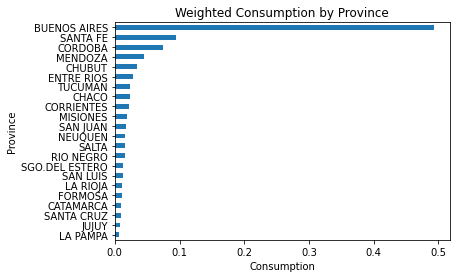

In [29]:
# Grouping Consumption by Province, calculating weight and plotting:
df_prov = df_month_prov.groupby('PROVINCIA')[['PROVINCIA','DEMANDA [MWh]']].sum()
df_prov['Weight'] = df_prov['DEMANDA [MWh]'] / df_prov['DEMANDA [MWh]'].sum()
df_prov['Weight'].sort_values().plot(kind='barh')
plt.xlabel('Consumption')
plt.ylabel('Province')
plt.title('Weighted Consumption by Province');
df_prov['Weight'].sort_values(ascending=False)

Buenos Aires represents almost half of the Country´s Energy Consumption. I will add to this dataframe coordinates of the biggest city of each province to find the weighted average center of the country´s energy consumption:  

In [30]:
# Reading Province´s Coordinates into a dataframe:
df_coord = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/Provinces Coordinates.xlsx')
df_coord.head()

PROVINCIA   Latitud  Longitud
0  BUENOS AIRES -34.61315 -58.37723
1     CATAMARCA -28.46957 -65.78524
2         CHACO -27.46056 -58.98389
3        CHUBUT -43.30016 -65.10228
4       CORDOBA -31.41350 -64.18105

In [31]:
# Merging both dataframes:
df_prov = df_prov.merge(df_coord, on='PROVINCIA')
print(df_prov.head())

      PROVINCIA  DEMANDA [MWh]    Weight   Latitud  Longitud
0  BUENOS AIRES   2.747156e+08  0.492618 -34.61315 -58.37723
1     CATAMARCA   5.708801e+06  0.010237 -28.46957 -65.78524
2         CHACO   1.271900e+07  0.022808 -27.46056 -58.98389
3        CHUBUT   1.872105e+07  0.033570 -43.30016 -65.10228
4       CORDOBA   4.165941e+07  0.074703 -31.41350 -64.18105


In [32]:
# Plotting in a map each province's energy consumption to visually understand distribution:
fig = px.scatter_mapbox(
    df_prov,  
    lat='Latitud',
    lon='Longitud',
    width=600,  # Width of map
    height=600,  # Height of map
    size='Weight',
    zoom=3,
    center={'lat': -40,'lon': -65},
    hover_data=['Weight'],  # Display Consumption's weight when hovering mouse over province
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [33]:
# Weighted Latitud and Longitud calculation:
lat = (df_prov['Weight'] * df_prov['Latitud']).sum()
lon = (df_prov['Weight'] * df_prov['Longitud']).sum()
print('lat: ',lat)
print('lon: ', lon)

lat:  -33.4270719126139
lon:  -60.954207296053504


Searching those coordinates in Google Maps we can see that average weighted coordinates are just 50 km away of Rosario, Santa Fe province:

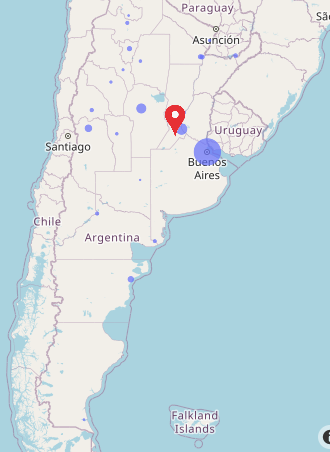

I will calculate each province's distance to the calculated country center:

In [34]:
# Distance from weighted center to each province calculation, and sorting to find out the minimum distance:
df_prov['distance'] = ((df_prov['Latitud'] - lat)**2 + (df_prov['Longitud'] - lon)**2)**0.5
df_prov[['PROVINCIA','distance']].sort_values(by='distance').head()

PROVINCIA  distance
19      SANTA FE  0.574279
6     ENTRE RIOS  1.748891
0   BUENOS AIRES  2.836828
4        CORDOBA  3.803549
9       LA PAMPA  4.610487

Excellent! Then it's defined Rosario, Santa Fe as the average weighted center of the country´s energy consumption.

**Second Step:**

Now it's time to import information about sunrise and sunset and merge that info with the dataframe of hourly consumption. New features will be the amount of sun hours a day has, and a boolean feature expressing if in an specific hour there is sunlight or not.

In [35]:
# Read Sun information from csv into dataframe and print first 5 rows and datatypes:
df_sun_hours = pd.read_csv('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/rosario_sun_data.csv', sep=';')
print(df_sun_hours.head())
print(' ')
print(df_sun_hours.dtypes)

          Dia   Salida    Puesta Horas de sol
0  01/01/2018  5:58:55  20:15:38     14:16:43
1  02/01/2018  5:59:39  20:15:49     14:16:10
2  03/01/2018  6:00:24  20:15:58     14:15:34
3  04/01/2018  6:01:11  20:16:05     14:14:54
4  05/01/2018  6:01:58  20:16:10     14:14:12
 
Dia             object
Salida          object
Puesta          object
Horas de sol    object
dtype: object


In [36]:
# Converting feature to the correct dtype:
df_sun_hours['Date'] = pd.to_datetime(df_sun_hours['Dia'], format='%d/%m/%Y')
df_sun_hours['Sunrise'] = pd.to_datetime(df_sun_hours['Salida'], format='%H:%M:%S')
df_sun_hours['Sunset'] = pd.to_datetime(df_sun_hours['Puesta'], format='%H:%M:%S')
df_sun_hours['Sun Hours'] = pd.to_datetime(df_sun_hours['Horas de sol'], format='%H:%M:%S')
df_sun_hours['Sun Hours'] = df_sun_hours['Sun Hours'].dt.hour + df_sun_hours['Sun Hours'].dt.minute / 60 + df_sun_hours['Sun Hours'].dt.second / 3600
df_sun_hours.drop(columns=['Dia', 'Salida', 'Puesta', 'Horas de sol'], inplace=True)
df_sun_hours.dtypes

Date         datetime64[ns]
Sunrise      datetime64[ns]
Sunset       datetime64[ns]
Sun Hours           float64
dtype: object

In [37]:
# Merging original dataset with sun information:
df = df.merge(df_sun_hours, on='Date')
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611  
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611

In [38]:
# Adding boolean feature:
sunrise_hour = df['Sunrise'].dt.hour
nightfall_hour = df['Sunset'].dt.hour
sun_1 = (sunrise_hour < df['Hour']).astype('int')
sun_2 = (nightfall_hour > df['Hour']).astype('int')
df['sun'] = sun_1 * sun_2
df[['Sunrise', 'Sunset', 'sun']].head(24)

Sunrise              Sunset  sun
0  1900-01-01 05:58:55 1900-01-01 20:15:38    0
1  1900-01-01 05:58:55 1900-01-01 20:15:38    0
2  1900-01-01 05:58:55 1900-01-01 20:15:38    0
3  1900-01-01 05:58:55 1900-01-01 20:15:38    0
4  1900-01-01 05:58:55 1900-01-01 20:15:38    0
5  1900-01-01 05:58:55 1900-01-01 20:15:38    0
6  1900-01-01 05:58:55 1900-01-01 20:15:38    1
7  1900-01-01 05:58:55 1900-01-01 20:15:38    1
8  1900-01-01 05:58:55 1900-01-01 20:15:38    1
9  1900-01-01 05:58:55 1900-01-01 20:15:38    1
10 1900-01-01 05:58:55 1900-01-01 20:15:38    1
11 1900-01-01 05:58:55 1900-01-01 20:15:38    1
12 1900-01-01 05:58:55 1900-01-01 20:15:38    1
13 1900-01-01 05:58:55 1900-01-01 20:15:38    1
14 1900-01-01 05:58:55 1900-01-01 20:15:38    1
15 1900-01-01 05:58:55 1900-01-01 20:15:38    1
16 1900-01-01 05:58:55 1900-01-01 20:15:38    1
17 1900-01-01 05:58:55 1900-01-01 20:15:38    1
18 1900-01-01 05:58:55 1900-01-01 20:15:38    1
19 1900-01-01 05:58:55 1900-01-01 20:15:38    1
20 1900-01-01 05:58:55 1900-01-01 20:15:38    0
21 1900-01-01 05:58:55 1900-01-01 20:15:38    0
22 1900-01-01 05:58:55 1900-01-01 20:15:38    0
23 1900-01-01 05:58:55 1900-01-01 20:15:38    0

Now I have the features I wanted to, I will plot this new information combined with previous information to understand how is related:

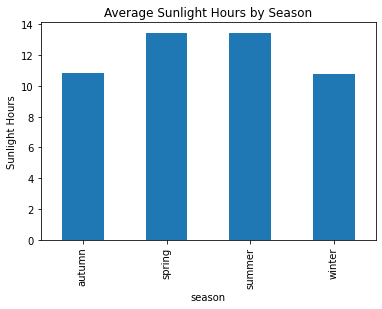

In [39]:
# Plotting average sunlight hours per Season:
df.groupby('season')['Sun Hours'].mean().plot(kind='bar')
plt.xlabel('season')
plt.ylabel('Sunlight Hours')
plt.title('Average Sunlight Hours by Season');

I will add the average sunrise and sunset hour to the Average Hourly Energy Consumption Summer and Winter plots: 

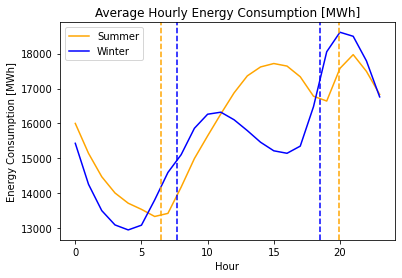

In [40]:
# Define average sunrise and sunset for each 
summer_sunrise = (df[df['season'] == 'summer']['Sunrise'].dt.hour + (df[df['season'] == 'summer']['Sunrise'].dt.minute)/60).mean()
summer_nightfall = (df[df['season'] == 'summer']['Sunset'].dt.hour + (df[df['season'] == 'summer']['Sunset'].dt.minute)/60).mean()
winter_sunrise = (df[df['season'] == 'winter']['Sunrise'].dt.hour + (df[df['season'] == 'winter']['Sunrise'].dt.minute)/60).mean()
winter_nightfall = (df[df['season'] == 'winter']['Sunset'].dt.hour + (df[df['season'] == 'winter']['Sunset'].dt.minute)/60).mean()
df[df['season'] == 'summer'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Summer', color='orange')
df[df['season'] == 'winter'].groupby('Hour')['Consumption [MWh]'].mean().plot(kind='line', label='Winter', color='blue')
plt.axvline(summer_sunrise, linestyle='--', color='orange')
plt.axvline(summer_nightfall, linestyle='--', color='orange')
plt.axvline(winter_sunrise, linestyle='--', color='blue')
plt.axvline(winter_nightfall, linestyle='--', color='blue')
plt.xlabel('Hour')
plt.ylabel('Energy Consumption [MWh]')
plt.title('Average Hourly Energy Consumption [MWh]')
plt.legend();

Longer summer days delay the consumption of energy. Shorter winter days make people start earlier in the morning and the afternoon to use electricity.

But Sun not only impacts in the natural light but also in Temperature, so next step will be to add to the dataset information about temperature and precipitations. 

**Third Step:**

I will now import from Meteostat´s API (https://dev.meteostat.net/python/hourly.html#example) climate information such as Temperature and Precipitations.

After doing that I'll add that information to the dataset.

In [41]:
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(lat, lon)
station = stations.fetch(1)

# Print DataFrame
print(station)

                    name country region    wmo  icao  latitude  longitude  \
id                                                                          
87480  Rosario Aerodrome      AR      S  87480  SAAR  -32.9167   -60.7833   

       elevation                        timezone hourly_start hourly_end  \
id                                                                         
87480       25.0  America/Argentina/Buenos_Aires   1939-02-01 2022-06-05   

      daily_start  daily_end monthly_start monthly_end      distance  
id                                                                    
87480  1965-03-08 2022-06-01    1950-01-01  2021-01-01  58937.917873  


In [42]:
# Set time period
start = datetime(2018, 1, 1)
end = datetime(2022, 12, 31, 23, 59)

# Get hourly data
data = Hourly(station, start, end)
data = data.fetch()

# Print DataFrame
print(data.head(5))
print('')
print(data.index.max())

                     temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                           
2018-01-01 00:00:00  20.7  19.2  91.0   NaN   NaN  160.0  13.0   NaN  1010.4   
2018-01-01 01:00:00  21.0  18.9  88.0   NaN   NaN  140.0  16.6   NaN  1011.0   
2018-01-01 02:00:00  21.0  16.0  73.0   NaN   NaN  110.0  22.3   NaN  1011.0   
2018-01-01 03:00:00  20.2  16.2  78.0   NaN   NaN  110.0  20.5   NaN  1011.5   
2018-01-01 04:00:00  20.0  16.0  78.0   NaN   NaN  140.0   9.4   NaN  1011.0   

                     tsun  coco  
time                             
2018-01-01 00:00:00   NaN   NaN  
2018-01-01 01:00:00   NaN   NaN  
2018-01-01 02:00:00   NaN   NaN  
2018-01-01 03:00:00   NaN   NaN  
2018-01-01 04:00:00   NaN   NaN  

2021-12-31 23:00:00


There seems to be a limit of 3 years so I will fetch for remaining information:

In [43]:
# Set time period
start = datetime(2022, 1, 1)
end = datetime(2022, 3, 31, 23, 59)

# Get hourly data
data_2 = Hourly(station, start, end)
data_2 = data_2.fetch()

# Print DataFrame
print(data_2.head(5))
print('')
print(data_2.index.max())

                     temp  dwpt  rhum  prcp  snow  wdir  wspd  wpgt    pres  \
time                                                                          
2022-01-01 00:00:00  31.7  15.2  37.0   NaN   NaN  70.0   9.4   NaN  1001.1   
2022-01-01 01:00:00  29.8  14.4  39.0   NaN   NaN  70.0  11.2   NaN  1001.2   
2022-01-01 02:00:00  28.7  14.9  43.0   NaN   NaN  90.0   9.4   NaN  1001.2   
2022-01-01 03:00:00  27.5  14.5  45.0   NaN   NaN  90.0   7.6   NaN  1001.6   
2022-01-01 04:00:00  26.6  14.4  47.0   NaN   NaN  90.0   3.6  18.5  1001.4   

                     tsun  coco  
time                             
2022-01-01 00:00:00   NaN   2.0  
2022-01-01 01:00:00   NaN   2.0  
2022-01-01 02:00:00   NaN   2.0  
2022-01-01 03:00:00   NaN   2.0  
2022-01-01 04:00:00   NaN   2.0  

2022-03-31 23:00:00


In [44]:
# Concatenate both dataframes and check shape:
climate = pd.concat([data, data_2])
print(climate.index.max())
print('')
print(climate.shape)

2022-03-31 23:00:00

(45971, 11)


It should had 37.944 rows at most. I will remove duplicates and recheck shape:

In [45]:
climate.drop_duplicates(keep='first', inplace=True)
climate.shape

(37119, 11)

In [46]:
# Drop columns we won´t use
climate.reset_index(drop=False, inplace=True)
climate.rename(columns={'time': 'datetime'}, inplace=True)
# climate['Hour'] = climate['datetime'].dt.hour
# climate['Date'] = [datetime.date() for datetime in climate['datetime']]
# climate['Date'] = pd.to_datetime(climate['Date'])
climate.drop(columns=['dwpt', 'rhum', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'], inplace=True)
climate.head()


datetime  temp  prcp
0 2018-01-01 00:00:00  20.7   NaN
1 2018-01-01 01:00:00  21.0   NaN
2 2018-01-01 02:00:00  21.0   NaN
3 2018-01-01 03:00:00  20.2   NaN
4 2018-01-01 04:00:00  20.0   NaN

In [47]:
# Checkin null values:
print(climate.isna().sum())
print(climate.isna().sum()/climate.shape[0])

datetime        0
temp            3
prcp        15785
dtype: int64
datetime    0.000000
temp        0.000081
prcp        0.425254
dtype: float64


There are just 3 missing values for temperature. In the case of precipitations there are almost 15,000, 43%. Let´s plot prcp time series: 

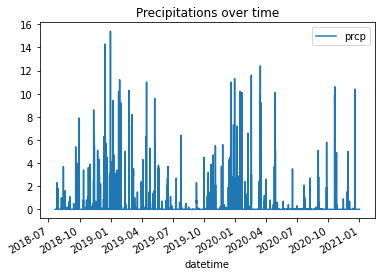

In [48]:
climate.plot(x='datetime', y='prcp')
plt.title('Precipitations over time');

Almost every missing value corresponds to the first half of 2018. Filling NaNs with average values means that at every hour of 2018's first semester was raining while filling them with 0 means that at no hour rained. I think both situations are not reliable so I will prefer to drop this feature.

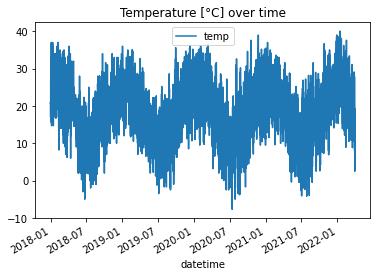

In [49]:
climate.drop(columns=['prcp'], inplace=True)
climate.plot(x='datetime', y='temp')
plt.title('Temperature [°C] over time');

In [50]:
# Adding temperature information to the dataframe:
df = df.merge(climate, how='left', on='datetime')
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  sun  \
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   

   temp  
0  20.7  
1  21.0  
2  21.0  
3  20.2  
4  20.0

In [51]:
# Checking for missing values:
df.isnull().sum()

Year                   0
Month                  0
Day                    0
Day Type               0
Date                   0
Hour                   0
Consumption [MWh]      0
season                 0
datetime               0
Sunrise                0
Sunset                 0
Sun Hours              0
sun                    0
temp                 828
dtype: int64

In [52]:
# Filling missing values with linear interpolation:
df.interpolate(axis=0, inplace=True)

In [53]:
# Re-checking for missing values:
df.isnull().sum()

Year                 0
Month                0
Day                  0
Day Type             0
Date                 0
Hour                 0
Consumption [MWh]    0
season               0
datetime             0
Sunrise              0
Sunset               0
Sun Hours            0
sun                  0
temp                 0
dtype: int64

**Fourth Step:**

I will now import information about economic activity level (EMAE) from INDEC and industrial activity level (IPI) from "Fundación Fiel":

In [54]:
economics = pd.read_excel('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/Economics 2018-2022.xlsx')
economics.head()

Year  Month   EMAE         IPI
0  2018      1  142.7  135.429394
1  2018      2  138.8  137.164394
2  2018      3  155.9  162.107533
3  2018      4  151.5  154.507462
4  2018      5  159.6  158.157595

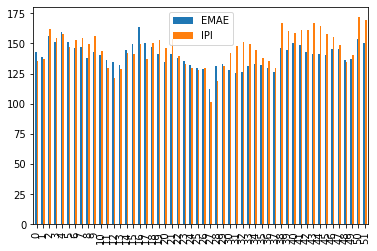

In [55]:
# Plotting both indicators:
economics[['EMAE', 'IPI']].plot(kind='bar');

In [56]:
# Adding information to the dataset:
df = df.merge(economics, how='left', on=['Year', 'Month'])
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  sun  \
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   

   temp   EMAE         IPI  
0  20.7  142.7  135.429394  
1  21.0  142.7  135.429394  
2  21.0  142.7  135.429394  
3  20.2  142.7  135.429394  
4  20.0  142.7  135.429394

**Fifth Step:**

From NASA (https://power.larc.nasa.gov/data-access-viewer/) I will import precipitions and Solar Radiation:

In [161]:
solar_rad = pd.read_csv('D:/Users/MARIANO/Mariano/Data Science/Proyecto Energía/solar_radiance.csv', sep=';', na_values=-999.0)
solar_rad.head()

Year  Month  Day  Hour  sol_rad  prcp
0  2018      1    1     0      0.0   0.0
1  2018      1    1     1      0.0   0.0
2  2018      1    1     2      0.0   0.0
3  2018      1    1     3      0.0   0.0
4  2018      1    1     4      0.0   0.0

In [162]:
solar_rad.shape

(37944, 6)

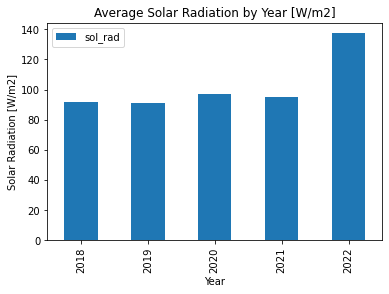

In [163]:
solar_rad.groupby(['Year'])[['sol_rad']].mean().plot(kind='bar')
plt.ylabel('Solar Radiation [W/m2]')
plt.title('Average Solar Radiation by Year [W/m2]');

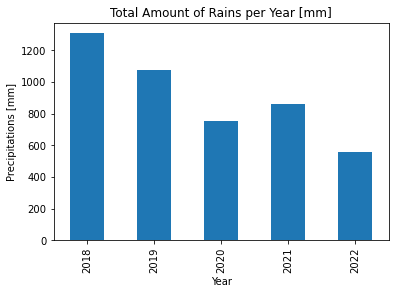

In [164]:
solar_rad.groupby(['Year'])['prcp'].sum().plot(kind='bar')
plt.ylabel('Precipitations [mm]')
plt.title('Total Amount of Rains per Year [mm]');

In [165]:
# Checking for missing values:
solar_rad.isna().sum()

Year          0
Month         0
Day           0
Hour          0
sol_rad    2736
prcp          0
dtype: int64

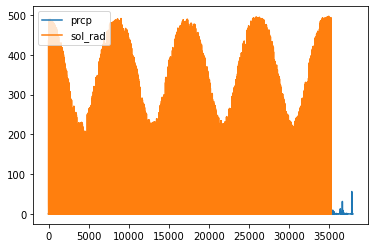

In [166]:
solar_rad[['prcp','sol_rad']].plot();

Solar Radiation has missing values for 2022 info. I will proceed to fill those values with average values for that Month, Day and Hour, considering wether it was raining or not, as radiation differs if day is cloudy (raining).

In [167]:
# Creating a column to differentiate raining hours from not raining hours:
solar_rad['rain'] = [1 if prcp > 0 else 0 for prcp in solar_rad['prcp']]
solar_rad[solar_rad['rain'] == 1].head()

Year  Month  Day  Hour  sol_rad  prcp  rain
49   2018      1    3     1     0.00  0.01     1
50   2018      1    3     2     0.00  0.01     1
51   2018      1    3     3     0.00  0.01     1
101  2018      1    5     5     0.00  0.36     1
102  2018      1    5     6    14.75  0.82     1

In [168]:
# Calculating average solar radiation for each Month, Day, Hour and Rain status:
sol_rad_avg_rain = pd.DataFrame(solar_rad.groupby(['Month', 'Day', 'Hour', 'rain'])['sol_rad', 'prcp'].mean())
sol_rad_avg_rain.reset_index(inplace=True)
sol_rad_avg_rain.rename(columns={'sol_rad': 'sol_rad_avg_rain', 'prcp': 'prcp_avg_rain'}, inplace=True)
sol_rad_avg_rain.head()

<ipython-input-168-202426635f53>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Month  Day  Hour  rain  sol_rad_avg_rain  prcp_avg_rain
0      1    1     0     0               0.0           0.00
1      1    1     0     1               0.0           0.01
2      1    1     1     0               0.0           0.00
3      1    1     1     1               0.0           0.01
4      1    1     2     0               0.0           0.00

In [169]:
# Merging both Dataframes:
solar_rad = solar_rad.merge(sol_rad_avg_rain, on=['Month', 'Day', 'Hour', 'rain'])

In [170]:
# Creating a Series to use in the fill na:
values_sol_rad_rain = pd.Series(solar_rad['sol_rad_avg_rain'])
values_sol_rad_rain.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: sol_rad_avg_rain, dtype: float64

In [171]:
values_sol_rad_rain.isna().sum()

195

In [172]:
# Filling missing values and checking:
solar_rad['sol_rad'].fillna(value=values_sol_rad_rain, inplace=True)
solar_rad.isna().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
sol_rad             195
prcp                  0
rain                  0
sol_rad_avg_rain    195
prcp_avg_rain         0
dtype: int64

In [173]:
# Calculating average solar radiation for each Month, Day, Hour:
sol_rad_avg = pd.DataFrame(solar_rad.groupby(['Month', 'Day', 'Hour'])['sol_rad'].mean())
sol_rad_avg.reset_index(inplace=True)
sol_rad_avg.rename(columns={'sol_rad': 'sol_rad_avg'}, inplace=True)
sol_rad_avg.head()

Month  Day  Hour  sol_rad_avg
0      1    1     0          0.0
1      1    1     1          0.0
2      1    1     2          0.0
3      1    1     3          0.0
4      1    1     4          0.0

In [174]:
# Merging both Dataframes:
solar_rad = solar_rad.merge(sol_rad_avg, on=['Month', 'Day', 'Hour'])
solar_rad.head()

Year  Month  Day  Hour  sol_rad  prcp  rain  sol_rad_avg_rain  \
0  2018      1    1     0      0.0  0.00     0               0.0   
1  2019      1    1     0      0.0  0.00     0               0.0   
2  2020      1    1     0      0.0  0.00     0               0.0   
3  2021      1    1     0      0.0  0.00     0               0.0   
4  2022      1    1     0      0.0  0.01     1               0.0   

   prcp_avg_rain  sol_rad_avg  
0           0.00          0.0  
1           0.00          0.0  
2           0.00          0.0  
3           0.00          0.0  
4           0.01          0.0

In [175]:
# Creating a Series to use in the fill na:
values_sol_rad = pd.Series(solar_rad['sol_rad_avg'])
values_sol_rad.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: sol_rad_avg, dtype: float64

In [176]:
# Filling missing values and checking:
solar_rad['sol_rad'].fillna(value=values_sol_rad, inplace=True)
solar_rad.isna().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
sol_rad               0
prcp                  0
rain                  0
sol_rad_avg_rain    195
prcp_avg_rain         0
sol_rad_avg           0
dtype: int64

In [177]:
# Dropping unnecessary columns:
solar_rad.drop(columns=['rain','sol_rad_avg_rain', 'prcp_avg_rain', 'sol_rad_avg'], inplace=True)

In [74]:
# Merging data:
df = df.merge(solar_rad, how='left', on=['Year', 'Month', 'Day', 'Hour'])
df.head()

Year  Month  Day Day Type       Date  Hour  Consumption [MWh]  season  \
0  2018      1    1   Sunday 2018-01-01     0          13115.471  summer   
1  2018      1    1   Sunday 2018-01-01     1          12748.214  summer   
2  2018      1    1   Sunday 2018-01-01     2          12450.384  summer   
3  2018      1    1   Sunday 2018-01-01     3          12114.221  summer   
4  2018      1    1   Sunday 2018-01-01     4          11846.796  summer   

             datetime             Sunrise              Sunset  Sun Hours  sun  \
0 2018-01-01 00:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
1 2018-01-01 01:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
2 2018-01-01 02:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
3 2018-01-01 03:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   
4 2018-01-01 04:00:00 1900-01-01 05:58:55 1900-01-01 20:15:38  14.278611    0   

   temp   EMAE         IPI  sol_rad  prcp  
0  20.7  142.7  135.429394      0.0   0.0  
1  21.0  142.7  135.429394      0.0   0.0  
2  21.0  142.7  135.429394      0.0   0.0  
3  20.2  142.7  135.429394      0.0   0.0  
4  20.0  142.7  135.429394      0.0   0.0

In [75]:
df.shape[0], solar_rad.shape[0]

(37944, 37944)

In [76]:
df.isna().sum()

Year                 0
Month                0
Day                  0
Day Type             0
Date                 0
Hour                 0
Consumption [MWh]    0
season               0
datetime             0
Sunrise              0
Sunset               0
Sun Hours            0
sun                  0
temp                 0
EMAE                 0
IPI                  0
sol_rad              0
prcp                 0
dtype: int64

**Sixth Step:**

With this new features I will perfom a new EDA to find insights.

To begin with, I will start with a headmap of correlations:

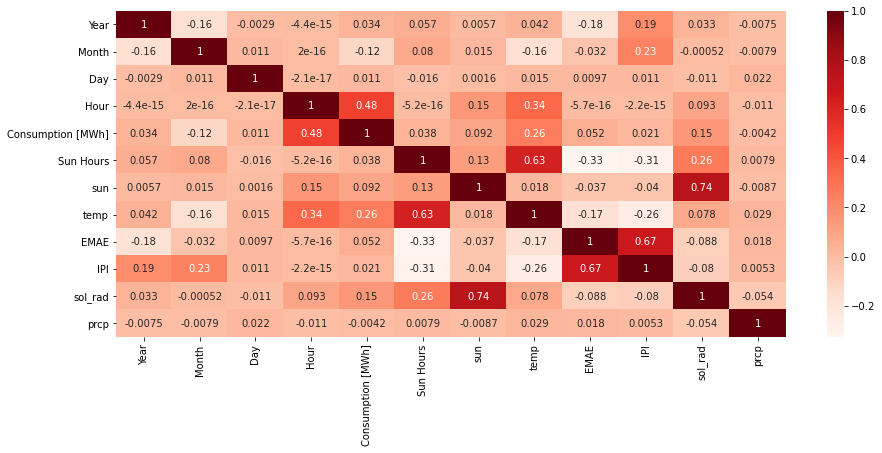

In [77]:
# Create a figure:
fig, ax = plt.subplots(figsize=(15, 6))
# Create matrix of correlations:
corr = df.corr()
# Plot correlations matrix into a heatmap:
sns.heatmap(corr, annot=True, cmap='Reds');

Consumption target feature has an hourly frequency. The other features that respond to hourly frequency are Hour, Sun and temperature. Sun hours has daily frequency and it´s related to daily consumption, while EMAE and IPI are monthly indicators. I will perform visualizations and correlation taking into account this frequencies.

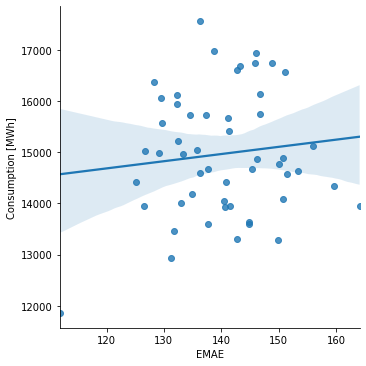

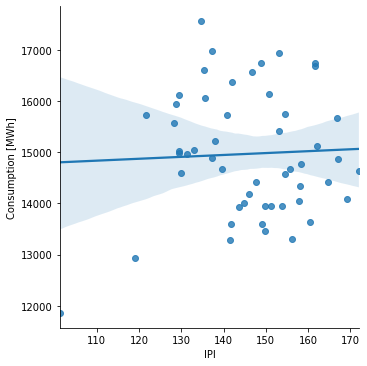

In [78]:
# Grouping information by Year and Month:
energy_vs_economics = df.groupby(['Year', 'Month'])[['Consumption [MWh]', 'EMAE', 'IPI']].mean()
# Plotting each economic indicator vs monthly average consumption:
sns.lmplot(data=energy_vs_economics, x='EMAE', y='Consumption [MWh]')
sns.lmplot(data=energy_vs_economics, x='IPI', y='Consumption [MWh]');

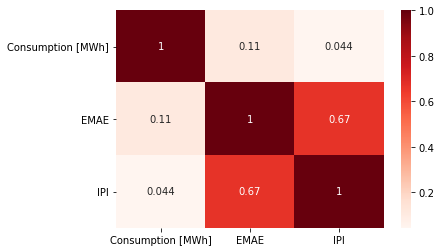

In [79]:
# Plot correlations matrix into a heatmap:
sns.heatmap(energy_vs_economics.corr(), annot=True, cmap='Reds');

Both graphs look alike with almost no linear correlation. Key takeaway is that EMAE and IPI are strongly correlated to each other so I will choose for the model only one of those features, the one that performs better.

I will continue with daily frequency with daily consumption, sun hours and day type, but also adding the monthly average temperature:

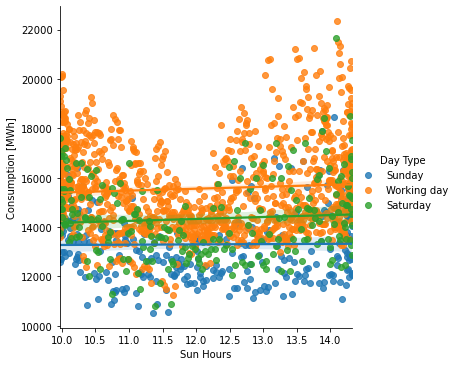

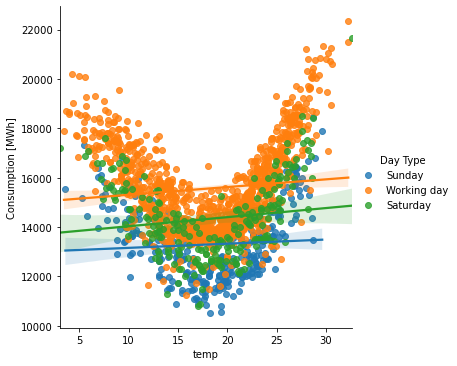

In [80]:
# Grouping consumption by year:
energy_vs_sunhours = df.groupby(['Year', 'Month', 'Day'])[['Consumption [MWh]', 'Sun Hours', 'temp']].mean()
# Merging with df to colour by Day Type:
energy_vs_sunhours = energy_vs_sunhours.merge(df[['Year', 'Month', 'Day', 'Day Type']].
                                              drop_duplicates(keep='first'), how='left', on=['Year', 'Month', 'Day'])
sns.lmplot(data=energy_vs_sunhours, x='Sun Hours', y='Consumption [MWh]', hue='Day Type');
sns.lmplot(data=energy_vs_sunhours, x='temp', y='Consumption [MWh]', hue='Day Type');

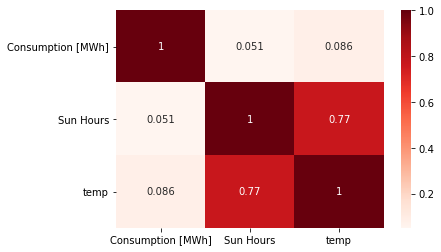

In [81]:
# Plot correlations matrix into a heatmap:
sns.heatmap(energy_vs_sunhours[['Consumption [MWh]', 'Sun Hours', 'temp']].corr(), annot=True, cmap='Reds');

Day Type has a big influence in energy consumption. Low and high Sun Hours (Winter and Summer) as well as low and high temperatures explain peaks in energy consumption. Monthly Sun hours and Temperature are highly correlated. There's no need to keep one of the them as in the dataset they have different frequencies.

I will continue now with hourly frequencies features: boolean Sun's presence, temperature and hourly energy consumption:

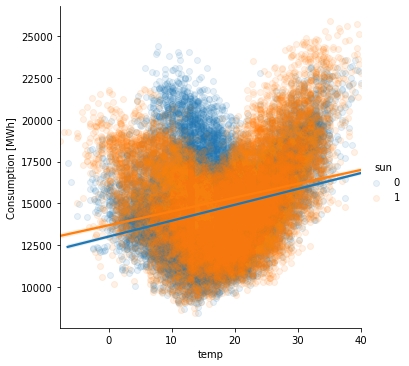

In [82]:
# Plotting Consumtion vs Temperature, color by sun's presence:
sns.lmplot(data=df, x='temp', y='Consumption [MWh]', hue='sun', scatter_kws={'alpha':0.1});

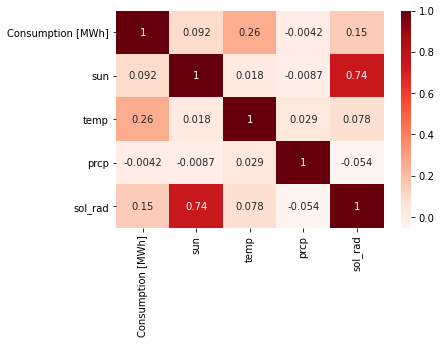

In [83]:
# Plot correlations matrix into a heatmap:
sns.heatmap(df[['Consumption [MWh]', 'sun', 'temp', 'prcp', 'sol_rad']].corr(), annot=True, cmap='Reds');

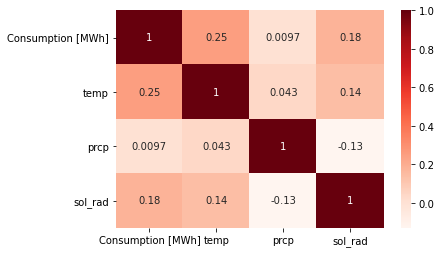

In [84]:
sns.heatmap(df[df['sun'] == 1][['Consumption [MWh]', 'temp', 'prcp', 'sol_rad']].corr(), annot=True, cmap='Reds');

This plot just confirms the impact of temperature (low and high) in energy consumption. The curve's shape looks more like a parabolic, explaining the low linear correlation rate.

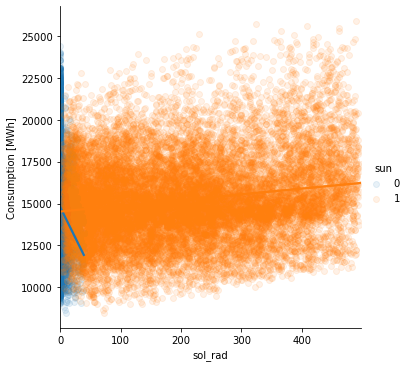

In [85]:
# Plotting Consumtion vs Solar Radiation, color by sun's presence:
sns.lmplot(data=df, x='sol_rad', y='Consumption [MWh]', hue='sun', scatter_kws={'alpha':0.1});

## 3) Model Selection

In this part of the project I will develop regression models to predict energy consumption base in the new features added to the dataset (temperature, sun hours, sun's presence, solar radiance, rains and economics). The only features that will remain from the original dataset will be the hour, season and day type.

As we could see in previous section, there are no strong linear correlations between features and target variable (energy consumption), so I will train and test tree based models.

**Input Preparation:**

As this is a time series dataset, I will split it into 3 to perform cross validation and hyperparameter tunning.

In [400]:
# Printing df columns
df.columns

Index(['Year', 'Month', 'Day', 'Day Type', 'Date', 'Hour', 'Consumption [MWh]',
       'season', 'datetime', 'Sunrise', 'Sunset', 'Sun Hours', 'sun', 'temp',
       'EMAE', 'IPI', 'sol_rad', 'prcp'],
      dtype='object')

In [401]:
# Choosing features to be used in the model selection:
model_features = ['Day Type', 'Hour', 'Sun Hours', 'temp', 'IPI', 'season', 'sol_rad', 'sun', 'EMAE']
target = ['Consumption [MWh]']
# Defining X and y:
X = df[model_features]
y = df[target]
# Printing shapes:
print(X.shape, y.shape)

(37944, 9) (37944, 1)


**First Model**: *Decision Tree Regressor*

Now, I will start to develop the first model: a Decision Tree Regressor. To do so I will start by building a pipeline with an Ordinal Encoder to transform categorical features (Day Type and Season) into numerical features, and a Decision Tree Regressor with default hyperparameters:

In [348]:
# Make a pipeline with a first step of encoding categorical features (Season and Day Type) + initializating a 
# Decison Tree Regressor and splitting Time Series data into 3 folds:
oe = OrdinalEncoder()
dt = DecisionTreeRegressor(random_state=1)
pipe_dt = make_pipeline(oe, dt)
tscv = TimeSeriesSplit(n_splits = 3)
splits = tscv.split(X)
cv_train_rmse = []
cv_test_rmse = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe_dt.fit(X_train, y_train.values.ravel())
    y_pred_train = pipe_dt.predict(X_train)
    y_pred_test = pipe_dt.predict(X_test)
    cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
    cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
# Compute average RSME:
dt_train_rmse = np.mean(cv_train_rmse)
dt_test_rmse = np.mean(cv_test_rmse)
print("Decision Tree Train RMSE:", dt_train_rmse.round(2))
print("Decision Tree Test RMSE:", dt_test_rmse.round(2))
print("Max_depth:", pipe_dt[1].get_depth())

Decision Tree Train RMSE: 0.0
Decision Tree Test RMSE: 1509.19
Max_depth: 35


I will plot feature importance to better understand how model to decides:

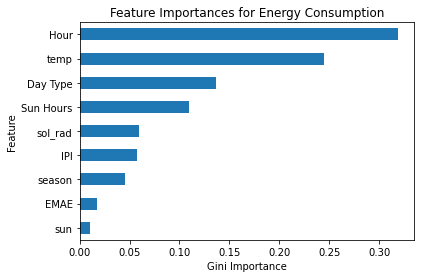

In [349]:
# Get importances and feature_names:
importance = pipe_dt[1].feature_importances_
features = pipe_dt[0].get_feature_names()
feat_imp = pd.Series(importance, index=features).sort_values(key=abs)
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Energy Consumption');

We can see that boolean feature of Sun's presence has no importance at all. And as we thought in EDA section we just can keep one of the economics features (IPI and EMAE). I will choose IPI as it is more important.

In [402]:
drop_features = ['sun', 'EMAE']
X.drop(drop_features, axis=1, inplace=True)

C:\Users\Mariano\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [403]:
# Update features to be considered in features list:
model_features = [f for f in model_features if f not in drop_features]
model_features

['Day Type', 'Hour', 'Sun Hours', 'temp', 'IPI', 'season', 'sol_rad']

Let's check out if model performs better without those unwanted features:

In [324]:
# Make a pipeline with a first step of encoding categorical features (Season and Day Type) + initializating a 
# Decison Tree Regressor and splitting Time Series data into 3 folds:
oe = OrdinalEncoder()
dt = DecisionTreeRegressor(random_state=1)
pipe_dt = make_pipeline(oe, dt)
tscv = TimeSeriesSplit(n_splits = 3)
splits = tscv.split(X)
cv_train_rmse = []
cv_test_rmse = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe_dt.fit(X_train, y_train.values.ravel())
    y_pred_train = pipe_dt.predict(X_train)
    y_pred_test = pipe_dt.predict(X_test)
    cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
    cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
# Compute average RSME:
dt_train_rmse = np.mean(cv_train_rmse)
dt_test_rmse = np.mean(cv_test_rmse)
print("Decision Tree Train RMSE:", dt_train_rmse.round(2))
print("Decision Tree Test RMSE:", dt_test_rmse.round(2))
print("Max_depth:", pipe_dt[1].get_depth())

Decision Tree Train RMSE: 0.0
Decision Tree Test RMSE: 1425.96
Max_depth: 36


We can see that this model has no error for train data, but it do has error for test data. That means that de model is overfitting, it learned train data but can´t replicate that performance with unseen data. To fix this hyperparameter tunning must be done. First let´s see what parameters this model has:

In [325]:
pipe_dt[1].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

Most common hyperparameters to be tunned in a Decision Tree are max_depth and min_samples_leaf. The first model fit to a max_depth of 36 and had min_samples_leaf default of 1.

Now I will perform a Cross Validation to find optimal values for max depth and min_samples_leaf:

In [326]:
# Hyperparameters to be tested:
max_depths = np.arange(5, 51, 5)
min_samples_leaf = np.arange(2, 11, 2)
# Creating dictionaries and list to keep record of perfomance:
dt_results = {}
max_depth_list = []
min_samples_leaf_list = []
train_rmse = []
test_rmse = []
# For loop to train and test each hyperparameters combination with Time Series Splits:
for md in max_depths:
    for msl in min_samples_leaf:
        dt = DecisionTreeRegressor(random_state=1, max_depth=md, min_samples_leaf=msl)
        pipe_dt = make_pipeline(oe, dt)
        tscv = TimeSeriesSplit(n_splits = 3)
        splits = tscv.split(X)
        cv_train_rmse = []
        cv_test_rmse = []
        for train_index, test_index in splits:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe_dt.fit(X_train, y_train)
            y_pred_train = pipe_dt.predict(X_train)
            y_pred_test = pipe_dt.predict(X_test)
            cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
            cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
        max_depth_list.append(md)
        min_samples_leaf_list.append(msl)
        train_rmse.append(np.mean(cv_train_rmse))
        test_rmse.append(np.mean(cv_test_rmse))

# Building dictionary with performance:        
dt_results['max_depth'] = max_depth_list
dt_results['min_samples_leaf'] = min_samples_leaf_list
dt_results['train_rmse'] = train_rmse
dt_results['test_rmse'] = test_rmse
# Building a DataFrame from dictionary:
dt_results = pd.DataFrame(dt_results)
dt_results.head()

max_depth  min_samples_leaf   train_rmse    test_rmse
0          5                 2  1521.957085  1702.677046
1          5                 4  1521.957085  1702.677046
2          5                 6  1521.957085  1702.677046
3          5                 8  1522.299994  1702.852351
4          5                10  1522.347902  1702.945084

In [327]:
# Looking for minimum value test_rmse:
display(dt_results[dt_results['test_rmse'] == dt_results['test_rmse'].min()])
index = dt_results['test_rmse'].idxmin()
# Saving hyperparameters values:
md = dt_results['max_depth'][index]
msl = dt_results['min_samples_leaf'][index]

max_depth  min_samples_leaf  train_rmse    test_rmse
14         15                10  698.019782  1334.020258

Optimal value for max_depth was 15 and for min_samples_leaf was 10. This lead model to a better performance, with a RMSE of around 1335 vs 1425 of the model without being tunned.

Let's see how performance varied with the hyperparameters. I will plot performance vs max_depth for different min_samples_leaf values:

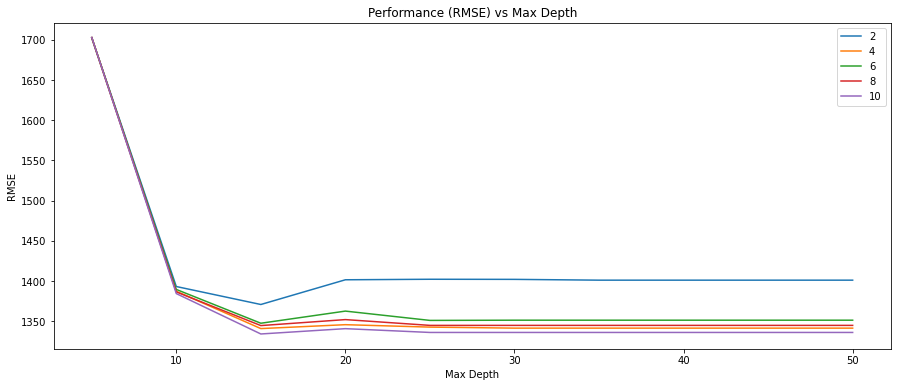

In [328]:
fig, ax = plt.subplots(figsize=(15, 6))
for msl in min_samples_leaf.tolist():
    dt_results[dt_results['min_samples_leaf'] == msl].plot(ax=ax, x='max_depth', y='test_rmse', label=msl)
    plt.xlabel('Max Depth')
    plt.ylabel('RMSE')
    plt.title('Performance (RMSE) vs Max Depth');

Decision Tree Regressor was fitted and hypertunned, ending with a RMSE of around 1335. Let's include it´s performance to performance dictionary and move on into a new model:

In [385]:
# Defining best model:
dt = DecisionTreeRegressor(random_state=1, max_depth=md, min_samples_leaf=msl)
pipe_dt = make_pipeline(oe, dt)
# Add RMSE to the performance dictionary:
model_performance['3 - Decision Tree'] = round(dt_results['test_rmse'].min(),2)
print(dt)
print(model_performance)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, random_state=1)
{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53, '3 - Decision Tree': 1334.02, '4 - Random Forest': 1193.76, '5 - XGB': 1374.31}


**Second Model**: *Random Forest Regressor*

Now, I will start to develop the second model: a Random Forest Regressor. I will proceed like I have done with the Decision Tree, following the same steps.

This algorithm is more time consuming than a decision tree, so I will asign more cpu (n_jobs).

In [386]:
# Printing number of cores in computer:
cpu = os.cpu_count()
print(cpu)

8


In [387]:
# Make a pipeline with a first step of encoding categorical features (Season and Type of Day) + 
# initializating a Random Forest Regressor and splitting Time Series data into 3 folds:
oe = OrdinalEncoder()
rf = RandomForestRegressor(random_state=1, n_jobs=cpu-2)
pipe_rf = make_pipeline(oe, rf)
tscv = TimeSeriesSplit(n_splits = 3)
splits = tscv.split(X)
cv_train_rmse = []
cv_test_rmse = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe_rf.fit(X_train, y_train.values.ravel())
    y_pred_train = pipe_rf.predict(X_train)
    y_pred_test = pipe_rf.predict(X_test)
    cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
    cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
# Compute average RSME:
rf_train_rmse = np.mean(cv_train_rmse)
rf_test_rmse = np.mean(cv_test_rmse)
print("Random Forest Train RMSE:", rf_train_rmse.round(2))
print("Random Forest Test RMSE:", rf_test_rmse.round(2))

Random Forest Train RMSE: 219.26
Random Forest Test RMSE: 1193.76


In [388]:
pipe_rf[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 6,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Feature's importances look similar to the decision tree model. 

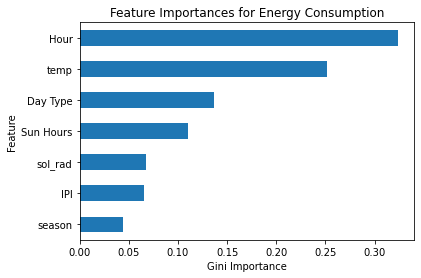

In [334]:
# Get importances and feature_names:
importance = pipe_rf[1].feature_importances_
features = pipe_rf[0].get_feature_names()
feat_imp = pd.Series(importance, index=features).sort_values(key=abs)
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Energy Consumption');

Random Forest with 100 estimators had a RMSE of almost 1190. 

Now I will perform a Cross Validation to find optimal value for some hyperparameters:

In [389]:
# Hyperparameters to be tune:
n_estimators = [100, 250, 500]
max_depths = [15, 30, 45]
min_samples_leaf = [3, 6]
max_features = ['auto', None]
# Creating dictionaries and list to keep record of perfomance:
rf_results = {}
max_depth_list = []
min_samples_leaf_list = []
n_estimators_list = []
max_features_list = []
train_rmse = []
test_rmse = []
# For loop to train and test each hyperparameters combination with Time Series Splits:
for n_est in n_estimators:
    for max_f in max_features:
        for md in max_depths:
            for msl in min_samples_leaf:
                rf = RandomForestRegressor(random_state=1, n_jobs=cpu-2, n_estimators = n_est, max_features = max_f, 
                                           max_depth=md, min_samples_leaf=msl)
                pipe_rf = make_pipeline(oe, rf)
                tscv = TimeSeriesSplit(n_splits = 3)
                splits = tscv.split(X)
                cv_train_rmse = []
                cv_test_rmse = []
                for train_index, test_index in splits:
                    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                    pipe_rf.fit(X_train, y_train.values.ravel())
                    y_pred_train = pipe_rf.predict(X_train)
                    y_pred_test = pipe_rf.predict(X_test)
                    cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
                    cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
                n_estimators_list.append(n_est)
                max_features_list.append(max_f)
                max_depth_list.append(md)
                min_samples_leaf_list.append(msl)
                train_rmse.append(np.mean(cv_train_rmse))
                test_rmse.append(np.mean(cv_test_rmse))

# Building dictionary with performance:        
rf_results['n_estimators'] = n_estimators_list
rf_results['max_features'] = max_features_list
rf_results['max_depth'] = max_depth_list
rf_results['min_samples_leaf'] = min_samples_leaf_list
rf_results['train_rmse'] = train_rmse
rf_results['test_rmse'] = test_rmse

# Building a DataFrame from dictionary:
rf_results = pd.DataFrame(rf_results)
rf_results.head()

n_estimators max_features  max_depth  min_samples_leaf  train_rmse  \
0           100         auto         15                 3  462.298437   
1           100         auto         15                 6  563.985047   
2           100         auto         30                 3  393.214124   
3           100         auto         30                 6  533.982924   
4           100         auto         45                 3  393.196860   

     test_rmse  
0  1183.593214  
1  1188.768734  
2  1181.799145  
3  1185.879008  
4  1181.818585

In [390]:
# Looking for minimum value test_rmse:
display(rf_results[rf_results['test_rmse'] == rf_results['test_rmse'].min()])

n_estimators max_features  max_depth  min_samples_leaf  train_rmse  \
14           250         auto         30                 3  391.464319   
20           250         None         30                 3  391.464319   

      test_rmse  
14  1179.283533  
20  1179.283533

There was not much improvement with a more expensive model, so I will stick to the first model created (pipe_rf):

In [409]:
# Define best model:
rf = RandomForestRegressor(random_state=1, n_jobs=cpu-2)
pipe_rf = make_pipeline(oe, rf)
# Add RMSE to the performance dictionary:
model_performance['4 - Random Forest'] = rf_test_rmse.round(2)
print(model_performance)

{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53, '3 - Decision Tree': 1334.02, '4 - Random Forest': 1193.76, '5 - XGB': 1243.71}


**Third Model**: *XGBoost Regressor*

Lastly, I will start to develop the third model: a XGBoost Regressor. I will proceed like I have done with previous models:

In [392]:
# Make a pipeline with a first step of encoding categorical features (Season and Type of Day) + 
# initializating a XGBoost Regressor:
xgb = XGBRegressor(seed=1, n_jobs=6, booster='gbtree', verbosity=0, eval_metric='rmse')
pipe_xgb = make_pipeline(oe, xgb)
pipe_xgb.fit(X_train, y_train)
tscv = TimeSeriesSplit(n_splits = 3)
splits = tscv.split(X)
cv_train_rmse = []
cv_test_rmse = []
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe_xgb.fit(X_train, y_train)
    y_pred_train = pipe_xgb.predict(X_train)
    y_pred_test = pipe_xgb.predict(X_test)
    cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
    cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
xgb_train_rmse = np.mean(cv_train_rmse)
xgb_test_rmse = np.mean(cv_test_rmse)
print("XGB Train RMSE:", xgb_train_rmse.round(2))
print("XGB Test RMSE:", xgb_test_rmse.round(2))

XGB Train RMSE: 355.05
XGB Test RMSE: 1243.71


First result for the XGB performed better than previous models. Let´s tune model to see if this performance can get better:

In [393]:
pipe_xgb[1].get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'seed': 1}

In [394]:
# Hyperparameters to be tune:
n_estimators = [100, 250, 500]
max_depths = [15, 30, 45]
subsample = [0.3, 0.5]
# Creating dictionaries and list to keep record of perfomance:
xgb_results = {}
max_depth_list = []
n_estimators_list = []
subsample_list = []
train_rmse = []
test_rmse = []
# For loop to train and test each hyperparameters combination with Time Series Splits:
for n_est in n_estimators:
    for md in max_depths:
        for ss in subsample:
            xgb = XGBRegressor(seed=1, n_jobs=cpu-2, booster='gbtree', verbosity=0, eval_metric='rmse', 
                               n_estimators=n_est, max_depth=md, subsample=ss)
            pipe_xgb = make_pipeline(oe, xgb)
            tscv = TimeSeriesSplit(n_splits = 3)
            splits = tscv.split(X)
            cv_train_rmse = []
            cv_test_rmse = []
            for train_index, test_index in splits:
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                pipe_xgb.fit(X_train, y_train)
                y_pred_train = pipe_xgb.predict(X_train)
                y_pred_test = pipe_xgb.predict(X_test)
                cv_train_rmse.append(mean_squared_error(y_train, y_pred_train) ** 0.5)            
                cv_test_rmse.append(mean_squared_error(y_test, y_pred_test) ** 0.5)
            n_estimators_list.append(n_est) 
            max_depth_list.append(md)
            subsample_list.append(ss)
            train_rmse.append(np.mean(cv_train_rmse))
            test_rmse.append(np.mean(cv_test_rmse))

# Building dictionary with performance:        
xgb_results['n_estimators'] = n_estimators_list
xgb_results['max_depth'] = max_depth_list
xgb_results['subsample'] = subsample_list
xgb_results['train_rmse'] = train_rmse
xgb_results['test_rmse'] = test_rmse

# Building a DataFrame from dictionary:
xgb_results = pd.DataFrame(xgb_results)
xgb_results.head()

n_estimators  max_depth  subsample   train_rmse    test_rmse
0           100          1        0.3  1316.725858  1604.879195
1           100          1        0.5  1323.562308  1616.592088
2           100         30        0.3    34.030640  1325.560455
3           100         30        0.5     2.369780  1265.505706
4           100         45        0.3    30.467667  1316.332525

In [395]:
# Looking for minimum value test_rmse:
display(xgb_results[xgb_results['test_rmse'] == xgb_results['test_rmse'].min()])
index = xgb_results['test_rmse'].idxmin()
# Saving hyperparameters values:
n_est = xgb_results['n_estimators'][index]
md = xgb_results['max_depth'][index]
ss = xgb_results['subsample'][index]
# Saving best performance:
xgb_best_rmse = xgb_results['test_rmse'][index]

n_estimators  max_depth  subsample  train_rmse    test_rmse
3           100         30        0.5     2.36978  1265.505706

XGBoost regressor went from 1245 to 1265. It didn´t get better and didn´t outperformed Random Forest. So the model to be used in the next section will be a Random Forest.

To end with model selection part of the project I will plot feature importances for XGB regressor, save the best model and add performance to dictionary:

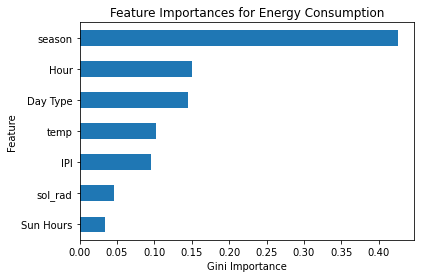

In [396]:
# Get importances and feature_names:
importance = pipe_xgb[1].feature_importances_
features = pipe_xgb[0].get_feature_names()
feat_imp = pd.Series(importance, index=features).sort_values(key=abs)
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Energy Consumption');

XGBoost Regressor change significantly feature importances vs Decision Tree or Random Forest Regressors.

{'0 - Mean': 2681.08, '1 - AR': 2660.49, '2 - AR_wfv': 171.53, '3 - Decision Tree': 1334.02, '4 - Random Forest': 1193.76, '5 - XGB': 1243.71}


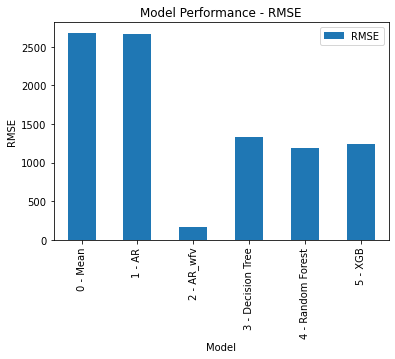

In [452]:
xgb = XGBRegressor(seed=1, n_jobs=6, booster='gbtree', verbosity=0, eval_metric='rmse')
pipe_xgb = make_pipeline(oe, xgb)
# Add RMSE to the performance dictionary:
model_performance['5 - XGB'] = xgb_test_rmse.round(2)
print(model_performance)
pd.DataFrame.from_dict(model_performance, orient = 'index', columns=['RMSE']).plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Performance - RMSE');

## 4) Energy Consumption Predictions 

Finally we reach the last part of the project, where I will use the Random Forest Regressor to predict energy consumption for actual time zone and for different scenarios:

    -> UTC -2 
    -> UTC -3 (Actual time zone)
    -> UTC -4
    -> UTC -5 

### A. Data Preparation:

**First Step:**

To begin with I will add to the selected features the 'Date' as it will be used to change time zone between scenarios. Then I will create one dataframe for each of the mentioned scenarios, dropping 'Date' so this dataframes can feed the model:

In [404]:
# Adding data to features:
model_features.append('Date') 
model_features.append('Consumption [MWh]')
model_features

['Day Type',
 'Hour',
 'Sun Hours',
 'temp',
 'IPI',
 'season',
 'sol_rad',
 'Date',
 'Consumption [MWh]']

In [405]:
cutoff_predict = '2018-01-01'

In [460]:
# Df for predictions slicing:
df_predict = df[(df['Date'] >= cutoff_predict)][model_features]
y = df_predict[target]
# Printing shape and % of split:
print(df_predict.shape, round(df_predict.shape[0]/df.shape[0],2))
print(df_predict.head(5))
print(y.shape)

(37944, 9) 1.0
  Day Type  Hour  Sun Hours  temp         IPI  season  sol_rad       Date  \
0   Sunday     0  14.278611  20.7  135.429394  summer      0.0 2018-01-01   
1   Sunday     1  14.278611  21.0  135.429394  summer      0.0 2018-01-01   
2   Sunday     2  14.278611  21.0  135.429394  summer      0.0 2018-01-01   
3   Sunday     3  14.278611  20.2  135.429394  summer      0.0 2018-01-01   
4   Sunday     4  14.278611  20.0  135.429394  summer      0.0 2018-01-01   

   Consumption [MWh]  
0          13115.471  
1          12748.214  
2          12450.384  
3          12114.221  
4          11846.796  
(37944, 1)


In [461]:
X = df_predict.drop(columns=['Date', 'Consumption [MWh]'])
pipe_rf.fit(X, y.values.ravel())

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Day Type', 'season'],
                                mapping=[{'col': 'Day Type',
                                          'data_type': dtype('O'),
                                          'mapping': Sunday         1
Working day    2
Saturday       3
NaN           -2
dtype: int64},
                                         {'col': 'season',
                                          'data_type': dtype('O'),
                                          'mapping': summer    1
autumn    2
winter    3
spring    4
NaN      -2
dtype: int64}])),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=6, random_state=1))])

I will build two functions. One to change hour to the dataframe, and another one to predict energy consumption:

In [462]:
def change_hour(df, start, end, hour):
    new_df = df.copy()
    dates = pd.date_range(start, end)
    new_hour = []
    for i in new_df.index:
        if new_df['Date'][i] in dates:
            new_hour.append(new_df['Hour'][i] + hour)
        else:
            new_hour.append(new_df['Hour'][i])
    new_hour = [h + 24 if h < 0 else h - 24 if h > 23 else h for h in new_hour]
    new_df['Hour'] = new_hour
    return new_df

In [463]:
def make_prediction(df):
    X = df.drop(columns=['Date', 'Consumption [MWh]'])
    pred = pipe_rf.predict(X)
    return pred

Using both created functions I will proceed to predict consumptions for the different time zones and store results in a DataFrame:

In [464]:
# Define iterable with hour difference vs actual scenario:
hour_change = np.arange(-2, 2, 1)
predictions = {'Date': df_predict['Date'],
               'Hour': df_predict['Hour'],
               'Actual': df_predict['Consumption [MWh]']}
# For loop to predict and store predictions:
for hour in hour_change:
    key = ('UTC'+str(hour-3))
    pred = make_prediction(change_hour(df_predict, start = '2018-01-01', end = '2022-05-01', hour=hour))
    predictions[key] = pred


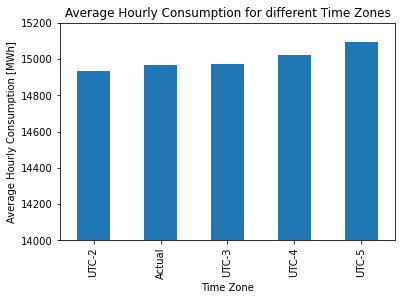

In [487]:
# Building a Dataframe from dictionary:
predictions = pd.DataFrame(predictions)
# Setting date as index and adding some datetime features:
predictions.set_index('Date', inplace=True)
predictions['Year'] = pd.to_datetime(predictions.index).year
predictions['Month'] = pd.to_datetime(predictions.index).month
predictions['Day'] = pd.to_datetime(predictions.index).day

Now I will proceed to make some visualizations for different time frequencies, in order to better understand results:

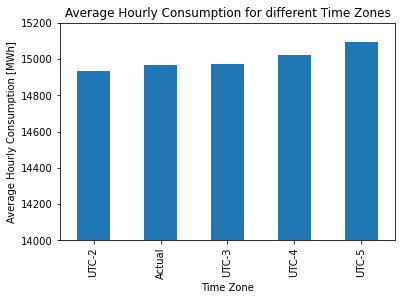

In [487]:
# Plotting average results:
predictions[['Actual', 'UTC-3', 'UTC-4', 'UTC-2', 'UTC-5']].mean().sort_values().round(2).plot(kind='bar', ylim=(14000,15200))
plt.xlabel('Time Zone')
plt.ylabel('Average Hourly Consumption [MWh]')
plt.title('Average Hourly Consumption for different Time Zones');

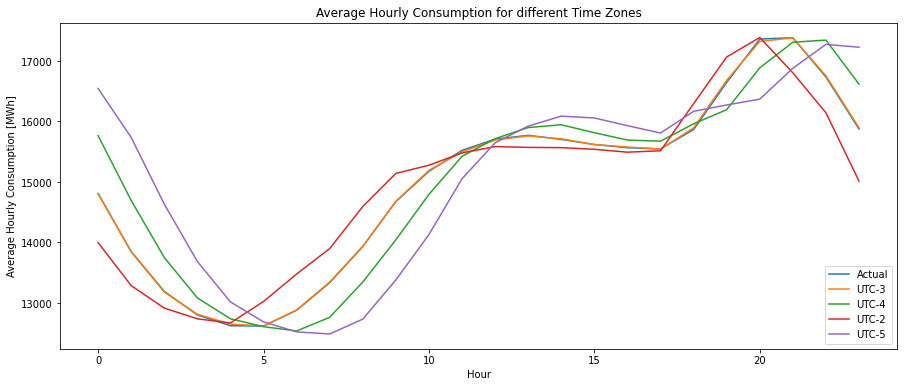

In [492]:
# Plotting average consumption by hour:
fig, ax = plt.subplots(figsize=(15, 6))
predictions.groupby('Hour')[['Actual', 'UTC-3', 'UTC-4', 'UTC-2', 'UTC-5']].mean().plot(ax=ax)
plt.xlabel('Hour')
plt.ylabel('Average Hourly Consumption [MWh]')
plt.title('Average Hourly Consumption for different Time Zones');

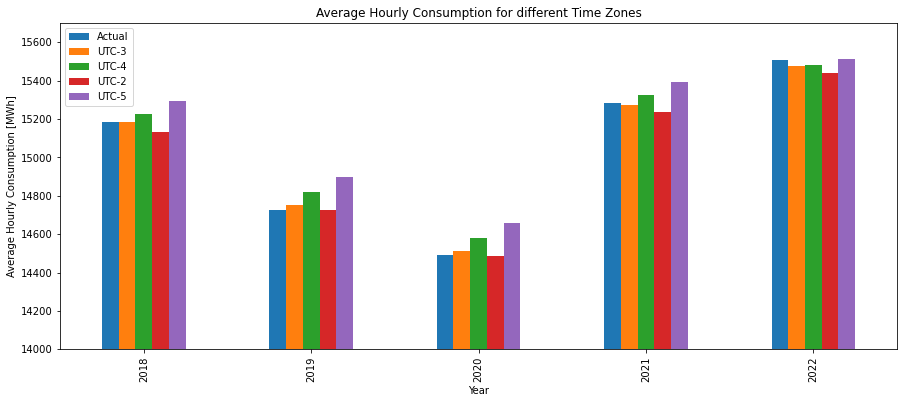

In [493]:
# Plotting average consumption by year:
fig, ax = plt.subplots(figsize=(15, 6))
predictions.groupby('Year')[['Actual', 'UTC-3', 'UTC-4', 'UTC-2', 'UTC-5']].mean().plot(ax=ax, kind='bar', ylim=(14000,15700))
plt.xlabel('Year')
plt.ylabel('Average Hourly Consumption [MWh]')
plt.title('Average Hourly Consumption for different Time Zones');

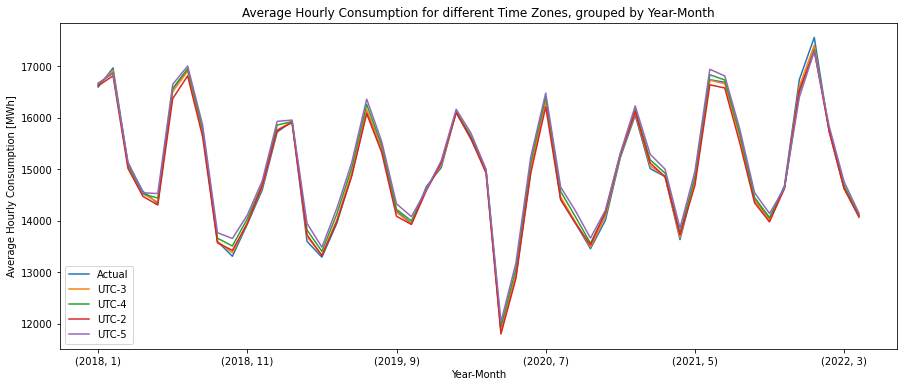

In [496]:
# Grouping consumption by Year-Month and plotting:
fig, ax = plt.subplots(figsize=(15, 6))
monthly_predictions = predictions.groupby(['Year', 'Month'])[['Actual', 'UTC-3', 'UTC-4', 'UTC-2', 'UTC-5']].mean().plot(ax=ax)
plt.xlabel('Year-Month')
plt.ylabel('Average Hourly Consumption [MWh]')
plt.title('Average Hourly Consumption for different Time Zones, grouped by Year-Month');

Even though the results were not what I expected, I really enjoyed doing this project. From its design, through writing the code and thinking about different alternatives. There is a lot of learning in doing things yourself, overcoming obstacles and looking for solutions in multiple ways.

Next steps are to continue working with data from particular provinces like Mendoza that is the furthest province UTC-3, looking for some experts in the subject that may help find new features or change the perspective, as well as some experts in data science that could help build better models.